In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load import add_noise, load_data
from utils.params import set_param

warnings.filterwarnings("ignore")

sns.set_theme(style="ticks")
np.random.seed(42)

In [3]:
exp = "p4581"
params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, Y, t, dt, vl = load_data(exp, dirs, params)
Y = Y[:, 0:2]

In [4]:
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[
        "det_shear_stress",
        "obs_shear_stress",
        "obs_normal_stress",
        "time",
    ],
)
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [5]:
df = df.rolling(window=int(1e3), step=int(1e3)).mean().dropna()
df = df.reset_index(drop=True)

In [6]:
df = df.dropna()
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.010441,1.306805,2.989703,0.500503
1,0.023812,1.320308,2.989567,1.500508
2,0.033829,1.330455,2.989649,2.500513
3,0.040971,1.337728,2.989704,3.500518
4,0.045985,1.342874,2.989764,4.500523


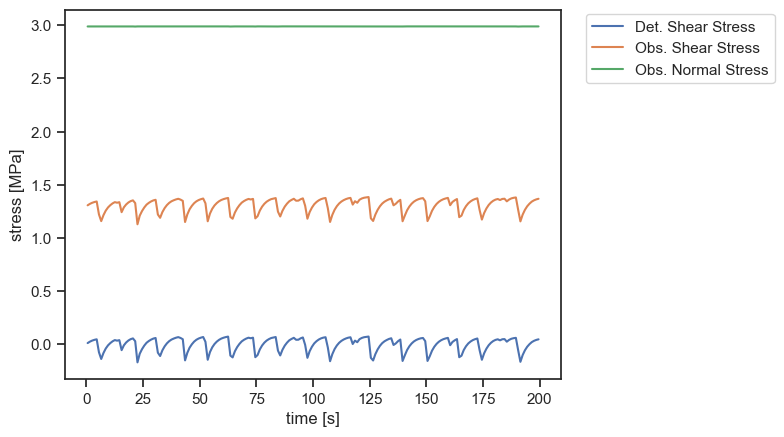

In [7]:
plt.plot(df["time"], df["det_shear_stress"], label="Det. Shear Stress")
plt.plot(df["time"], df["obs_shear_stress"], label="Obs. Shear Stress")
plt.plot(df["time"], df["obs_normal_stress"], label="Obs. Normal Stress")
plt.legend(loc=(1.05, 0.8))
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [ ]:
from scipy.signal import argrelextrema

def find_local_minima(time_series):
    series_array = time_series.to_numpy()
    minima_indices = argrelextrema(series_array, np.less)[0]
    local_minima = time_series.iloc[minima_indices]
    return local_minima

def get_time2failure(type="start"):
    failure_points = np.zeros(df.shape[0])
    if type == "start":
        failure_points[find_local_minima(-1*df["det_shear_stress"]).index] = 1
    else:
        failure_points[find_local_minima(df["det_shear_stress"]).index] = 1
    ttf = pd.Series(np.zeros(df.shape[0]) , index=df.index)
    last_failure_time = None
    for time_point in reversed(df.index):
        if failure_points[time_point]: last_failure_time = time_point
        if last_failure_time is not None: ttf[time_point] = last_failure_time - time_point
    return ttf

In [10]:
ttsf = get_time2failure(type="start")
ttef = get_time2failure(type="end")

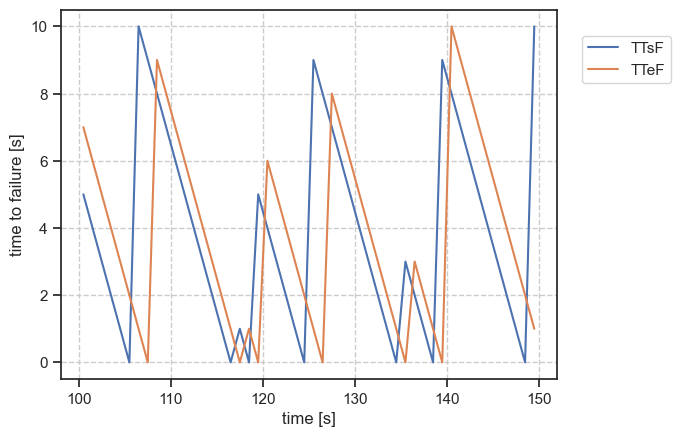

In [11]:
plt.plot(df["time"][100:150], ttsf[100:150], label="TTsF")
plt.plot(df["time"][100:150], ttef[100:150], label="TTeF")
plt.legend(loc=(1.05, 0.8))
plt.xlabel("time [s]")
plt.ylabel("time to failure [s]")
plt.grid(ls="--")
plt.show()